In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [4]:
#load some data
base_url = "https://raw.githubusercontent.com/NocturneBear/NBA-Data-2010-2024/main/"
files = [
    "regular_season_box_scores_2010_2024_part_1.csv",
    "regular_season_box_scores_2010_2024_part_2.csv",
    "regular_season_box_scores_2010_2024_part_3.csv",
    "play_off_box_scores_2010_2024.csv"
]
dfs = [pd.read_csv(base_url + f) for f in files]

playoffs = dfs[3]
rs1 = dfs[0]
rs2 = dfs[1]
rs3 = dfs[2]

In [8]:
rs1

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,...,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
0,2010-11,2010-11-10,21000112,NJN @ CLE,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,-4
1,2010-11,2010-11-17,21000165,NJN @ UTA,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,0
2,2010-11,2010-11-27,21000237,NJN @ PHI,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,0
3,2010-11,2010-12-12,21000351,NJN vs. LAL,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,0
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,...,0,1,1,1,0,0,1,1,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141488,2010-11,2010-12-17,21000389,HOU vs. MEM,1610612745,Houston,Rockets,HOU,rockets,2449,...,3,6,9,2,0,1,6,2,23,39
141489,2011-12,2012-03-02,21100534,HOU vs. DEN,1610612745,Houston,Rockets,HOU,rockets,2449,...,1,3,4,1,0,0,2,1,13,-4
141490,2010-11,2010-11-17,21000164,HOU @ OKC,1610612745,Houston,Rockets,HOU,rockets,2449,...,2,6,8,0,0,0,3,3,26,-8
141491,2011-12,2012-02-08,21100383,HOU @ POR,1610612745,Houston,Rockets,HOU,rockets,2449,...,1,1,2,2,0,1,4,3,12,-5


In [27]:
regular = pd.concat([rs1, rs2, rs3], ignore_index=True)
regular['is_playoff'] = 0
playoffs['is_playoff'] = 1

df = pd.concat([regular, playoffs], ignore_index=True)

#format
df.drop(columns=['jerseyNum', 'comment', 'position', 'matchup'], inplace=True)
df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')

def convert_minutes(min_str):
    try:
        if pd.isna(min_str): return 0
        parts = min_str.split(':')
        return int(parts[0]) + int(parts[1]) / 60 if len(parts) == 2 else 0
    except: return 0

df['minutes_played'] = df['minutes'].apply(convert_minutes)
df.drop(columns=['minutes'], inplace=True)
df['season'] = df['season_year'].str[:4].astype(int)

#data aggs
agg = df.groupby(['personId', 'personName', 'game_date', 'is_playoff']).agg({
    'gameId': 'count',
    'minutes_played': 'sum',
    'points': 'sum',
    'assists': 'sum',
    'reboundsTotal': 'sum',
    'fieldGoalsMade': 'sum',
    'fieldGoalsAttempted': 'sum',
    'threePointersMade': 'sum',
    'freeThrowsMade': 'sum',
    'turnovers': 'sum',
    'plusMinusPoints': 'sum'
}).rename(columns={'gameId': 'games_played'}).reset_index().sort_values('game_date')

agg['ppm'] = (agg['points'] / agg['minutes_played']).dropna()
agg = agg[agg.minutes_played > 0]


# pivoted = agg.pivot_table(index=['personId', 'personName', 'season'], columns='is_playoff',
#                           values=['points', 'minutes_played', 'assists', 'reboundsTotal'], aggfunc='sum')
# pivoted.columns = ['_'.join(map(str, col)) for col in pivoted.columns]
# pivoted = pivoted.dropna()

# #per min stats
# pivoted['ppm_regular'] = pivoted['points_0'] / pivoted['minutes_played_0']
# pivoted['ppm_playoff'] = pivoted['points_1'] / pivoted['minutes_played_1']
# pivoted['residual_ppm'] = pivoted['ppm_playoff'] - pivoted['ppm_regular']


# #resids
# residual_series = pivoted.sort_values(['season', 'personId'])['residual_ppm'].reset_index(drop=True).dropna()

In [28]:
agg

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm
0,255,Grant Hill,2010-10-26,0,1,26.083333,4,1,1,2,4,0,0,3,-8,0.153355
78571,101236,Chuck Hayes,2010-10-26,0,1,14.816667,0,1,0,0,0,0,0,0,-9,0.000000
10294,1889,Andre Miller,2010-10-26,0,1,26.700000,10,9,2,4,8,0,2,3,14,0.374532
76536,101177,Fabricio Oberto,2010-10-26,0,1,3.050000,0,0,1,0,1,0,0,1,0,0.000000
9854,1885,Lamar Odom,2010-10-26,0,1,32.900000,14,1,10,7,10,0,0,4,11,0.425532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443407,1630639,AJ Lawson,2024-06-17,1,1,2.616667,0,0,0,0,0,0,0,0,3,0.000000
392057,1629052,Oshae Brissett,2024-06-17,1,1,0.650000,0,0,0,0,0,0,0,0,0,0.000000
369504,1628436,Luke Kornet,2024-06-17,1,1,2.033333,0,0,1,0,0,0,0,0,-2,0.000000
338596,1627759,Jaylen Brown,2024-06-17,1,1,44.250000,21,6,8,7,23,2,5,1,20,0.474576


In [40]:
agg[agg.ppm.isna()]

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm


In [98]:
agg

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm
0,255,Grant Hill,2010-10-26,0,1,26.083333,4,1,1,2,4,0,0,3,-8,0.153355
78571,101236,Chuck Hayes,2010-10-26,0,1,14.816667,0,1,0,0,0,0,0,0,-9,0.000000
10294,1889,Andre Miller,2010-10-26,0,1,26.700000,10,9,2,4,8,0,2,3,14,0.374532
76536,101177,Fabricio Oberto,2010-10-26,0,1,3.050000,0,0,1,0,1,0,0,1,0,0.000000
9854,1885,Lamar Odom,2010-10-26,0,1,32.900000,14,1,10,7,10,0,0,4,11,0.425532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443407,1630639,AJ Lawson,2024-06-17,1,1,2.616667,0,0,0,0,0,0,0,0,3,0.000000
392057,1629052,Oshae Brissett,2024-06-17,1,1,0.650000,0,0,0,0,0,0,0,0,0,0.000000
369504,1628436,Luke Kornet,2024-06-17,1,1,2.033333,0,0,1,0,0,0,0,0,-2,0.000000
338596,1627759,Jaylen Brown,2024-06-17,1,1,44.250000,21,6,8,7,23,2,5,1,20,0.474576


In [99]:
agg['points_lagged'] = agg.groupby('personId')['points'].shift(1)

In [103]:
import statsmodels.api as sm

In [105]:
agg_dropped= agg.dropna(subset = ['points_lagged', 'points'])

In [107]:

X = agg_dropped[['points_lagged']]
y = agg_dropped['points']


X_with_const = sm.add_constant(X) 

# Fit OLS model
model = sm.OLS(y, X_with_const)
results = model.fit()

# Print summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 1.946e+05
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:09:04   Log-Likelihood:            -1.2460e+06
No. Observations:              374379   AIC:                         2.492e+06
Df Residuals:                  374377   BIC:                         2.492e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1796      0.017    241.443

In [133]:
from pmdarima import auto_arima

In [ ]:
unique_players = agg.personName.unique()

filtered_out_players = []

print(len(unique_players))

player_predictions = []

for player in unique_players:
    sub = agg[agg.personName == player].query('minutes_played > 20')
    
    if len(sub) < 20:
        filtered_out_players.append(player)
        continue

    adf_stat, adf_p = adfuller(sub.ppm)[:2]
    # print(player, len(sub), f"\nADF Test:\nStat = {adf_stat:.4f}, p = {adf_p:.4f}")

    if adf_p > 0.05:
        # filtered out
        filtered_out_players.append(player)
        continue

    auto_model = auto_arima(df.ppm, 
                        start_p=0, max_p=5,   # Range for AR term
                        start_q=0, max_q=5,   # Range for MA term
                        seasonal=False,       # ARMA is non-seasonal
                        stepwise=True,        # Stepwise search
                        trace=True)           # Print model selection process

    # p, q, d = 1, 1, 1

    p, q, d = auto_model.order

    model = ARIMA(sub.reset_index()['ppm'], order = (p, q, d))
    fitted_model = model.fit()

    predictions = fitted_model.predict(start = max(p, q), end = len(sub) - 1, dynamic = False)
    
    new_sub = sub.copy().reset_index(drop=True)
    new_sub['predicted_ppm'] = predictions
    new_sub = new_sub.dropna(subset=['predicted_ppm'])

    player_predictions.append(new_sub)

    print(len(sub), adf_p, sum(new_sub.ppm.isna()), sum(new_sub.predicted_ppm.isna()))
    # print(new_sub[['ppm', 'predicted_ppm']])
    
    # print(player, r2_score(new_sub['ppm'], new_sub['predicted_ppm']))
    print(player, np.corrcoef(new_sub['ppm'], new_sub['predicted_ppm'])[0][1])
    # valid_data = new_sub.dropna(subset=['ppm', 'predicted_ppm'])

    # # Scatter plot
    # plt.figure(figsize=(6, 6))
    # plt.scatter(valid_data['ppm'], valid_data['predicted_ppm'], alpha=0.6, color='blue')

    # # Add a reference y=x line (ideal predictions)
    # plt.plot(valid_data['ppm'], valid_data['ppm'], linestyle="--", color="red", label="Perfect Fit")

    # # Labels & title
    # plt.xlabel("Actual PPM")
    # plt.ylabel("Predicted PPM")
    # plt.title(f"Prediction Scatter Plot for {player}")
    # plt.legend()

    # # Show plot
    # plt.show()
    

1712
128 0.0005274429110025522 0 0
Grant Hill 0.18753890180557425
115 0.00019634346777175333 0 0
Chuck Hayes 0.30455898079692073
279 3.566017103171543e-30 0 0
Andre Miller 0.04614935946525145
20 0.031147591091035126 0 0
Brad Miller 0.20701538351368737
377 5.498886210637081e-15 0 0
Dante Cunningham 0.19248416281997596
147 5.02240060819289e-19 0 0
Nate Robinson 0.1147677232086114
149 1.2543389018687452e-20 0 0
Chase Budinger 0.09247874772176796
46 2.6793758249001277e-10 0 0
Hakim Warrick 0.09517085295094337
433 6.656691508163099e-09 0 0
Paul Pierce 0.2206182024631975
316 4.727060774024306e-18 0 0
Channing Frye 0.22203068725254063
427 3.791558525749145e-25 0 0
Matt Barnes 0.11802761577410326
305 2.0263847364731056e-30 0 0
Luis Scola 0.20300905650625686
321 6.505282704058111e-08 0 0
Kevin Martin 0.32721839427641464
809 2.343104790805419e-21 0 0
LaMarcus Aldridge 0.13038352541352355
46 1.2495278285859637e-09 0 0
Brandon Roy 0.21195725226989398
185 4.1610956770779873e-19 0 0
Jason Richardson

In [126]:
df_full = pd.concat(player_predictions)

In [127]:
import seaborn as sns

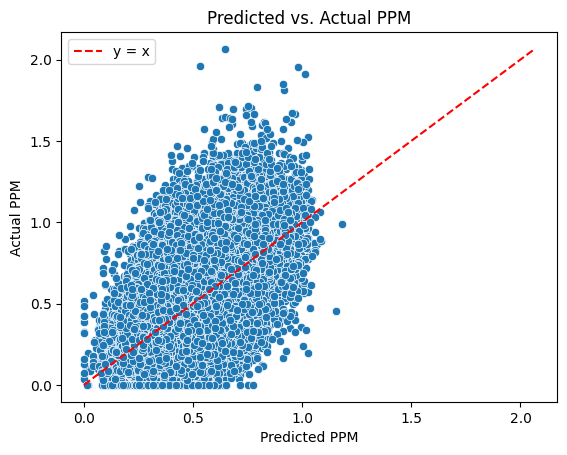

In [128]:
sns.scatterplot(df_full, x = 'predicted_ppm', y = 'ppm')
min_val = min(df_full[['predicted_ppm', 'ppm']].min())  # Get minimum value
max_val = max(df_full[['predicted_ppm', 'ppm']].max())  # Get maximum value
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="y = x")

# Labels & title
plt.xlabel("Predicted PPM")
plt.ylabel("Actual PPM")
plt.title("Predicted vs. Actual PPM")
plt.legend()


In [129]:
r2_score(df_full.ppm, df_full.predicted_ppm)

0.29975657656923693

In [130]:
df_full[['predicted_ppm', 'ppm']].corr()

,predicted_ppm,ppm
predicted_ppm,1.000000,0.548861
ppm,0.548861,1.000000


In [123]:
df_full

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm,points_lagged,predicted_ppm
1,255,Grant Hill,2010-10-28,0,1,28.750000,9,2,12,3,7,0,3,2,4,0.313043,4.0,0.153355
2,255,Grant Hill,2010-10-29,0,1,33.916667,21,2,3,10,17,0,1,0,-2,0.619165,9.0,0.227072
3,255,Grant Hill,2010-11-03,0,1,33.433333,15,1,8,5,11,1,4,0,5,0.448654,21.0,0.341718
4,255,Grant Hill,2010-11-05,0,1,23.533333,2,4,6,1,9,0,0,3,-3,0.084986,15.0,0.383985
5,255,Grant Hill,2010-11-07,0,1,22.950000,14,2,6,5,10,0,4,3,-10,0.610022,2.0,0.348629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,1641871,Duop Reath,2024-03-22,0,1,26.683333,13,2,3,5,10,2,1,3,-14,0.487196,8.0,0.533675
21,1641871,Duop Reath,2024-03-23,0,1,26.333333,24,2,8,9,14,3,3,2,9,0.911392,13.0,0.531107
22,1641871,Duop Reath,2024-03-25,0,1,23.983333,8,0,4,3,8,0,2,0,-15,0.333565,24.0,0.532222
23,1641871,Duop Reath,2024-03-27,0,1,30.216667,13,5,5,6,12,1,0,1,-16,0.430226,8.0,0.553525


In [62]:
sum(new_sub.predicted_ppm.isna())

19

In [71]:
new_sub[['ppm', 'predicted_ppm']].iloc[100:]

,ppm,predicted_ppm
100,0.320095,0.108870
101,0.067077,0.341619
102,0.404774,0.141464
103,0.360065,0.166995
104,0.213958,0.309778
105,0.293542,0.324244
106,0.484740,0.420191
107,0.283186,NaN
108,0.422337,0.207359
109,0.397112,0.414865


In [66]:
new_sub

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm,predicted_ppm
0,255,Grant Hill,2010-10-28,0,1,28.750000,9,2,12,3,7,0,3,2,4,0.313043,NaN
1,255,Grant Hill,2010-10-29,0,1,33.916667,21,2,3,10,17,0,1,0,-2,0.619165,NaN
2,255,Grant Hill,2010-11-03,0,1,33.433333,15,1,8,5,11,1,4,0,5,0.448654,0.472732
3,255,Grant Hill,2010-11-05,0,1,23.533333,2,4,6,1,9,0,0,3,-3,0.084986,0.834174
4,255,Grant Hill,2010-11-07,0,1,22.950000,14,2,6,5,10,0,4,3,-10,0.610022,0.672185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,255,Grant Hill,2013-03-26,0,1,5.600000,0,0,0,0,0,0,0,0,-9,0.000000,0.398854
154,255,Grant Hill,2013-03-30,0,1,13.833333,2,0,2,1,3,0,0,2,-1,0.144578,0.343035
155,255,Grant Hill,2013-04-13,0,1,11.466667,5,0,1,2,3,1,0,0,5,0.436047,0.320330
156,255,Grant Hill,2013-04-16,0,1,6.450000,2,0,2,1,3,0,0,0,-8,0.310078,0.392646


In [ ]:
player_predictions_df = pd.concat(player_predictions).sort_values('game_date')
player_predictions_df

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm,predicted_ppm
1,255,Grant Hill,2010-10-28,0,1,28.750000,9,2,12,3,7,0,3,2,4,0.313043,0.230032
2,255,Grant Hill,2010-10-29,0,1,33.916667,21,2,3,10,17,0,1,0,-2,0.619165,0.472732
3,255,Grant Hill,2010-11-03,0,1,33.433333,15,1,8,5,11,1,4,0,5,0.448654,0.834174
4,255,Grant Hill,2010-11-05,0,1,23.533333,2,4,6,1,9,0,0,3,-3,0.084986,0.672185
5,255,Grant Hill,2010-11-07,0,1,22.950000,14,2,6,5,10,0,4,3,-10,0.610022,0.228998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455348,1641998,Trey Jemison,2024-04-06,0,1,33.466667,5,2,7,2,6,0,1,3,-17,0.149402,0.674958
455349,1641998,Trey Jemison,2024-04-09,0,1,30.166667,14,2,9,6,14,0,2,1,-4,0.464088,0.173962
455350,1641998,Trey Jemison,2024-04-10,0,1,35.933333,4,3,9,2,7,0,0,1,-17,0.111317,0.450410
455351,1641998,Trey Jemison,2024-04-12,0,1,35.416667,6,0,5,3,4,0,0,1,8,0.169412,-0.027863


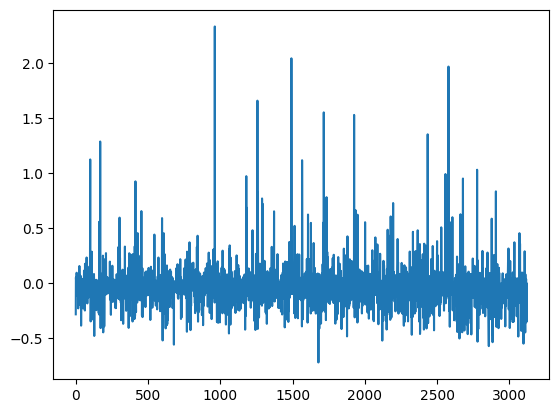

In [19]:
plt.plot(residual_series)

In [21]:
#adf tests
adf_stat, adf_p = adfuller(residual_series)[:2]
print(f"\nADF Test:\nStat = {adf_stat:.4f}, p = {adf_p:.4f}")

#stationary :0


ADF Test:
Stat = -53.5442, p = 0.0000


In [26]:




#diff
series_diff = residual_series.diff().dropna() if adf_p > 0.05 else residual_series

# armima pqd
best_aic = np.inf
best_order = None
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(residual_series, order=(p, 1, q)).fit()
            if model.aic < best_aic:
                best_aic, best_order, best_model = model.aic, (p, 1, q), model
        except:
            continue

print(f"\nBest ARIMA order: {best_order} with AIC: {best_aic:.2f}")




Best ARIMA order: (0, 1, 1) with AIC: -1600.38


In [30]:
#garch lol
returns = series_diff.pct_change().replace([np.inf, -np.inf], np.nan).dropna() * 100
garch = arch_model(returns, vol='GARCH', p=1, q=1)
garch_fitted = garch.fit(disp='off')
print("\nGARCH Summary:\n", garch_fitted.summary())




GARCH Summary:
                      Constant Mean - GARCH Model Results                      
Dep. Variable:           residual_ppm   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -28255.1
Distribution:                  Normal   AIC:                           56518.2
Method:            Maximum Likelihood   BIC:                           56542.1
                                        No. Observations:                 2963
Date:                Mon, Mar 31 2025   Df Residuals:                     2962
Time:                        02:39:05   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu           -58.9071     61.641     -0.956 

In [31]:
#lasso garch x (prof loves this)
X = pivoted[['assists_0', 'reboundsTotal_0']].reset_index(drop=True).loc[series_diff.index]
y = returns.loc[X.index]
lasso = LassoCV(cv=5).fit(X, y)
selected = np.where(lasso.coef_ != 0)[0]
selected_features = X.columns[selected]
print(f"\nSelected features by Lasso: {selected_features.tolist()}")

exog = X.iloc[:, selected]
garchx = arch_model(y, x=exog, vol='GARCH', p=1, q=1)
garchx_fitted = garchx.fit(disp='off')
print("\nGARCH-X Summary:\n", garchx_fitted.summary())

# r2
r2_arima = r2_score(residual_series[1:], best_model.predict(start=1, end=len(residual_series)-1))
print(f"\nARIMA R2: {r2_arima:.4f}")

# arima fit
plt.figure(figsize=(12, 6))
plt.plot(residual_series, label='Observed residual PPM')
plt.plot(best_model.predict(start=1, end=len(residual_series)-1), label='ARIMA Predicted')
plt.title("ARIMA Fit on Residual PPM (Playoff - Regular)")
plt.legend()
plt.tight_layout()
plt.show()

KeyError: '[0, 757] not in index'